# # Projeto de Match de Candidatos e Vagas
#
# Este notebook documenta o processo de desenvolvimento de um modelo de Machine Learning para prever o "match" (adequação) entre candidatos e vagas, utilizando informações textuais e numéricas. O objetivo é classificar se um candidato é "adequado" (classe 1) ou "não adequado" (classe 0) para uma vaga, considerando o desbalanceamento das classes.

1. Carregamento e Preparação dos Dados
Nesta primeira etapa, carregamos os conjuntos de dados brutos (vagas, candidatos e prospects) a partir de arquivos JSON e os estruturamos em DataFrames do pandas para facilitar as próximas etapas de análise e pré-processamento.

In [ ]:
import json
import pandas as pd

def load_json(path):
    with open(path, encoding='utf-8') as f:
        return json.load(f)

JOBS_PATH = r'C:\Users\Leonardo\Desktop\Codigos\vagas.json'
jobs_data = load_json(JOBS_PATH)

job_rows = []
for vaga_id, dados in jobs_data.items():
    info = dados.get("informacoes_basicas", {})
    perfil = dados.get("perfil_vaga", {})

    job_rows.append({
        'vaga_id': vaga_id,
        'titulo_vaga': info.get('titulo_vaga', ''),
        'prioridade_vaga': info.get('prioridade_vaga', ''),
        'tipo_contratacao_vaga': info.get('tipo_contratacao', ''),
        'vaga_sap': info.get('vaga_sap', ''),
        'nivel_profissional_vaga': perfil.get('nivel profissional', ''),
        'nivel_ingles_vaga': perfil.get('nivel_ingles', ''),
        'nivel_espanhol_vaga': perfil.get('nivel_espanhol', ''),
        'area_atuacao_vaga': perfil.get('areas_atuacao', ''),
        'local_vaga': perfil.get('cidade', ''),
        'principais_atividades_vaga': perfil.get('principais_atividades', ''),
        'competencias_tecnicas_vaga': perfil.get('competencia_tecnicas_e_comportamentais', '')
    })

df_jobs = pd.DataFrame(job_rows)


In [ ]:
APPLICANTS_PATH = r'C:\Users\Leonardo\Desktop\Codigos\applicants.json'
applicants_data = load_json(APPLICANTS_PATH)

applicant_rows = []
for candidato_id, dados in applicants_data.items():
    info = dados.get('infos_basicas', {})
    formacao = dados.get('formacao_e_idiomas', {})
    prof = dados.get('informacoes_profissionais', {})

    applicant_rows.append({
        'candidato_id': candidato_id,
        'nome': info.get('nome'),
        'email': info.get('email'),
        'local_candidato': info.get('local'),
        'nivel_ingles_candidato': formacao.get('nivel_ingles'),
        'nivel_espanhol_candidato': formacao.get('nivel_espanhol'),
        'nivel_academico_candidato': formacao.get('nivel_academico'),
        'area_atuacao_candidato': prof.get('area_atuacao'),
        'nivel_profissional_candidato': prof.get('nivel_profissional'),
        'conhecimentos_tecnicos_candidato': prof.get('conhecimentos_tecnicos'),
        'titulo_candidato': prof.get('titulo_profissional'),
        'objetivo_candidato': info.get('objetivo_profissional'),
        'cv': dados.get('cv_pt')
    })

df_applicants = pd.DataFrame(applicant_rows)


In [ ]:
from datetime import datetime


PROSPECTS_PATH = r'C:\Users\Leonardo\Desktop\Codigos\prospects.json'
prospects_data = load_json(PROSPECTS_PATH)

prospect_rows = []
for vaga_id, vaga_info in prospects_data.items():
    titulo_vaga = vaga_info.get('titulo', '')
    lista_prospects = vaga_info.get('prospects', [])

    for prospect in lista_prospects:
        candidato_id = prospect.get('codigo')
        situacao = prospect.get('situacao_candidado')
        data_candidatura = prospect.get('data_candidatura')
        ultima_atualizacao = prospect.get('ultima_atualizacao')

        # Cálculo da diferença de dias
        try:
            dt1 = datetime.strptime(data_candidatura, "%d-%m-%Y")
            dt2 = datetime.strptime(ultima_atualizacao, "%d-%m-%Y")
            dias_entre = (dt2 - dt1).days
        except:
            dias_entre = None

        prospect_rows.append({
            'vaga_id': vaga_id,
            'candidato_id': candidato_id,
            'situacao': situacao,
            'data_candidatura': data_candidatura,
            'ultima_atualizacao': ultima_atualizacao,
            'comentario': prospect.get('comentario'),
            'recrutador': prospect.get('recrutador'),
            'dias_entre_candidatura_e_ultima_atualizacao': dias_entre
        })

df_prospects = pd.DataFrame(prospect_rows)


In [ ]:

df_merged = df_prospects.merge(df_jobs, on='vaga_id', how='left')
df_merged = df_merged.merge(df_applicants, on='candidato_id', how='left')




### Preparação da Coluna TARGET

Nesta etapa, preparamos a variável alvo (`alvo`) para o modelo. Consideramos apenas os registros com status que indicam a conclusão do processo de seleção.

Registros com status inconclusivos (como 'prospect', 'encaminhado ao requisitante', 'sem interesse nesta vaga', etc.) foram excluídos, pois não fornecem um resultado claro de "match" ou "não match" para o treinamento do modelo.

A coluna `alvo` foi criada da seguinte forma:
- **`alvo = 1` (Match):** Para status considerados positivos (por exemplo, 'contratado', 'aprovado', 'proposta aceita').
- **`alvo = 0` (Não Match):** Para status considerados negativos (por exemplo, 'não aprovado', 'desistiu', 'recusado').

In [ ]:
STATUS_POSITIVOS = {'contratado pela decision', 'contratado como hunting', 'aprovado', 'proposta aceita'}
STATUS_NEGATIVOS = {'não aprovado pelo cliente', 'não aprovado pelo rh', 'desistiu', 'recusado', 'reprovado', 'não aprovado pelo requisitante'}


status_a_manter = STATUS_POSITIVOS.union(STATUS_NEGATIVOS)
status_a_manter_lower = {s.lower() for s in status_a_manter}


df_merged['situacao_lower'] = df_merged['situacao'].str.lower()


df_merged = df_merged[df_merged['situacao_lower'].isin(status_a_manter_lower)].copy()

df_merged = df_merged.drop(columns=['situacao_lower'])


df_merged = df_merged.reset_index(drop=True)


df_merged['alvo'] = 0


df_merged.loc[df_merged['situacao'].str.lower().isin(STATUS_POSITIVOS), 'alvo'] = 1


df_merged.loc[df_merged['situacao'].str.lower().isin(STATUS_NEGATIVOS), 'alvo'] = 0

### Engenharia de Features: Níveis de Idioma

Nesta etapa, criamos features numéricas a partir dos níveis de idioma (inglês e espanhol) para que o modelo possa utilizá-los. Os níveis textuais são mapeados para valores numéricos, e criamos features binárias que indicam se o nível de idioma do candidato atende ou excede o requisito da vaga.

In [ ]:


for col in ['nivel_ingles_vaga', 'nivel_espanhol_vaga', 'nivel_ingles_candidato', 'nivel_espanhol_candidato']:
    df_merged[col] = df_merged[col].replace('', 'Nenhum').fillna('Nenhum')


In [ ]:
df_merged[col] = df_merged[col].str.strip().str.title()


In [ ]:
mapa_idiomas = {
    'Nenhum': 0,
    'Básico': 1,
    'Técnico': 2,
    'Intermediário': 3,
    'Avançado': 4,
    'Fluente': 5
}


In [ ]:
for col in ['nivel_ingles_vaga', 'nivel_espanhol_vaga', 'nivel_ingles_candidato', 'nivel_espanhol_candidato']:
    df_merged[col + '_num'] = df_merged[col].map(mapa_idiomas)


In [ ]:
df_merged['match_nivel_ingles'] = (
    df_merged['nivel_ingles_candidato_num'] >= df_merged['nivel_ingles_vaga_num']
).astype(int)

df_merged['match_nivel_espanhol'] = (
    df_merged['nivel_espanhol_candidato_num'] >= df_merged['nivel_espanhol_vaga_num']
).astype(int)


### Preparação de Texto Combinado para Análise

Nesta etapa, concatenamos diversas informações textuais relevantes do candidato (como CV, conhecimentos técnicos, objetivo profissional) e da vaga (título, área de atuação, atividades, competências). O objetivo é criar campos de texto únicos e ricos em conteúdo para cada candidato e vaga, facilitando a análise textual e a extração de features para o modelo de match.

In [ ]:
df_merged['texto_candidato'] = (
    df_merged['cv'].fillna('') + ' ' +
    df_merged['conhecimentos_tecnicos_candidato'].fillna('') + ' ' +
    df_merged['nivel_profissional_candidato'].fillna('') + ' ' +
    df_merged['titulo_candidato'].fillna('') + ' ' +
    df_merged['objetivo_candidato'].fillna('')
)



In [ ]:
df_merged['texto_vaga'] = (
    df_merged['titulo_vaga'].fillna('') + ' ' +
    df_merged['area_atuacao_vaga'].fillna('') + ' ' +
    df_merged['principais_atividades_vaga'].fillna('') + ' ' +
    df_merged['competencias_tecnicas_vaga'].fillna('')
)


In [ ]:

(df_merged['texto_candidato'].str.strip() == '').sum()

np.int64(1714)

### Tratamento de Textos Vazios/Nulos

Após a criação das colunas de texto combinado (`texto_candidato` e `texto_vaga`), removemos as linhas que continham apenas valores em branco ou nulos nessas colunas para garantir a qualidade dos dados para a análise textual subsequente.

In [ ]:
df_merged = df_merged[df_merged['texto_candidato'].str.strip() != '']
df_merged = df_merged.dropna(subset=['texto_candidato'])

In [ ]:
df_merged = df_merged[df_merged['texto_vaga'].str.strip() != '']
df_merged = df_merged.dropna(subset=['texto_vaga'])


In [ ]:
df_merged['prioridade_vaga'].value_counts()

prioridade_vaga
Alta: Alta complexidade 3 a 5 dias        5137
                                          3603
Média: Média complexidade 6 a 10 dias      882
Baixa: Baixa complexidade 11 a 30 dias     227
Name: count, dtype: int64

In [ ]:
df_merged.loc[:, 'prioridade_vaga'] = df_merged['prioridade_vaga'].replace('', pd.NA).fillna('nenhum')

prioridade_map = {
    'Alta: Alta complexidade 3 a 5 dias': 'alta',
    'Média: Média complexidade 6 a 10 dias': 'media',
    'Baixa: Baixa complexidade 11 a 30 dias': 'baixa',
}
df_merged['prioridade_vaga'] = df_merged['prioridade_vaga'].replace(prioridade_map)

### Engenharia de Features: Localização

Nesta etapa, criamos features relacionadas à localização do candidato e da vaga. O objetivo é identificar possíveis *matches* geográficos, como candidatos que residem na mesma cidade da vaga, gerando uma feature binária que indica essa correspondência para ser utilizada no modelo.

In [ ]:
from unidecode import unidecode
import re
import numpy as np
def standardize_location_text(text):
    if pd.isna(text) or text == '':
        return np.nan
    text = str(text).lower()
    text = unidecode(text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_merged['local_vaga_tratado'] = df_merged['local_vaga'].apply(standardize_location_text)
df_merged['local_candidato_tratado'] = df_merged['local_candidato'].apply(standardize_location_text)

In [ ]:
df_merged['local_candidato_tratado'].value_counts().head(50)


local_candidato_tratado
sao paulo, sao paulo                   1510
rio de janeiro, rio de janeiro          203
belo horizonte, minas gerais            123
fortaleza, ceara                        120
sao paulo                               118
osasco, sao paulo                        96
sao bernardo do campo, sao paulo         90
campinas, sao paulo                      87
hortolandia, sao paulo                   85
curitiba, parana                         71
santo andre, sao paulo                   63
brasilia, distrito federal               52
guarulhos, sao paulo                     49
recife, pernambuco                       44
barueri, sao paulo                       41
porto alegre, rio grande do sul          29
salvador, bahia                          28
sorocaba, sao paulo                      25
santos, sao paulo                        25
sao caetano do sul, sao paulo            25
niteroi, rio de janeiro                  24
carapicuiba, sao paulo                   21
cotia, s

In [ ]:
df_merged['local_vaga_tratado'].value_counts().head(50)


local_vaga_tratado
sao paulo                6624
hortolandia               461
rio de janeiro            279
barueri                   266
sao bernardo do campo     256
fortaleza                 251
nova lima                 194
recife                    169
curitiba                  141
santana de parnaiba       132
belo horizonte            118
campinas                  102
sao leopoldo               78
ribeirao preto             53
santo andre                43
sao jose dos campos        42
uberlandia                 39
bebedouro                  38
porto alegre               36
brasilia                   28
sao carlos                 27
volta redonda              25
indaiatuba                 24
santos                     18
londrina                   17
blumenau                   17
guarulhos                  17
cruzeiro                   16
osasco                     15
sao luis                   13
manaus                     13
jundiai                    11
varginha             

In [ ]:
import pandas as pd
from unidecode import unidecode
import re
import numpy as np


def standardize_location_text(text):
    if pd.isna(text) or text == '':
        return np.nan
    text = str(text).lower()
    text = unidecode(text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df_merged['local_vaga_tratado'] = df_merged['local_vaga'].apply(standardize_location_text)
df_merged['local_candidato_tratado'] = df_merged['local_candidato'].apply(standardize_location_text)

print("local_candidato_tratado ANTES da remoção do estado:")
print(df_merged['local_candidato_tratado'].value_counts(dropna=False).head(10))


def remove_state_suffix(location_string):
    if pd.isna(location_string) or location_string.strip() == '':
        return np.nan

    return location_string.split(',')[0].strip()


df_merged['local_candidato_tratado'] = df_merged['local_candidato_tratado'].apply(remove_state_suffix)

print("\nlocal_candidato_tratado DEPOIS da remoção do estado:")
print(df_merged['local_candidato_tratado'].value_counts(dropna=False).head(10))

def create_simple_city_match_feature(row):
    loc_cand_city = row['local_candidato_tratado']
    loc_vaga_city = row['local_vaga_tratado']


    if pd.isna(loc_cand_city) or pd.isna(loc_vaga_city):
        return 0

    if loc_cand_city == loc_vaga_city:
        return 1

    return 0


df_merged['match_local_cidade_bin'] = df_merged.apply(create_simple_city_match_feature, axis=1)

print("\nValue counts para a nova feature 'match_local_cidade_bin':")
print(df_merged['match_local_cidade_bin'].value_counts(dropna=False))



local_candidato_tratado ANTES da remoção do estado:
local_candidato_tratado
NaN                                 6061
sao paulo, sao paulo                1510
rio de janeiro, rio de janeiro       203
belo horizonte, minas gerais         123
fortaleza, ceara                     120
sao paulo                            118
osasco, sao paulo                     96
sao bernardo do campo, sao paulo      90
campinas, sao paulo                   87
hortolandia, sao paulo                85
Name: count, dtype: int64

local_candidato_tratado DEPOIS da remoção do estado:
local_candidato_tratado
NaN                      6061
sao paulo                1628
rio de janeiro            213
belo horizonte            123
fortaleza                 120
osasco                     96
sao bernardo do campo      90
campinas                   87
hortolandia                85
curitiba                   71
Name: count, dtype: int64

Value counts para a nova feature 'match_local_cidade_bin':
match_local_cidade_bin
0

### Tratamento de Texto Detalhado

Aplicamos um tratamento mais detalhado aos textos combinados do candidato e da vaga. Esta etapa incluiu a remoção de acentuações, caracteres especiais, números e stopwords (palavras comuns sem grande significado para a análise, como "de", "a", "o", etc.) para preparar os textos para a análise e extração de features.

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
import unicodedata


nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

def preprocess_text(text):
    text = str(text).lower()
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

    text = text.replace('-', ' ')
    text = text.replace(',', '')
    text = text.replace('(', '')
    text = text.replace(')', '')

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)


df_merged['texto_completo_tratado'] = df_merged['texto_candidato'].apply(preprocess_text)
df_merged['texto_vaga_tratado'] = df_merged['texto_vaga'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leonardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Engenharia de Features: Nível Profissional/Senioridade

Nesta etapa, criamos features relacionadas ao nível profissional ou senioridade do candidato e da vaga. Identificamos palavras-chave de nível de cargo nos textos, mapeamos esses níveis para uma hierarquia numérica e criamos features que comparam o nível do candidato com o nível da vaga, indicando se há um match, se o candidato está acima ou abaixo do nível requerido.

In [ ]:
from unidecode import unidecode
import pandas as pd

palavras_chave = [
    'senior', 'analista', 'pleno', 'junior', 'especialista', 'assistente',
    'gerente', 'lider', 'coordenador', 'supervisor', 'auxiliar', 'trainee', 'aprendiz'
]

def identificar_palavras(texto):
    encontradas = [p for p in palavras_chave if p in texto]
    return '/'.join(encontradas) if encontradas else None

df_merged['palavras_nivel_cargo'] = df_merged['texto_completo_tratado'].apply(identificar_palavras)

df_merged[['texto_completo_tratado', 'palavras_nivel_cargo']].head()


df_merged['nivel_profissional_vaga'] = df_merged['nivel_profissional_vaga'].apply(
    lambda x: unidecode(str(x)).lower().strip() if pd.notna(x) else None
)

hierarquia = {
    'aprendiz': 1,
    'trainee': 2,
    'auxiliar': 3,
    'assistente': 4,
    'analista': 5,
    'junior': 6,
    'pleno': 7,
    'senior': 8,
    'especialista': 9,
    'supervisor': 10,
    'lider': 11,
    'coordenador': 12,
    'gerente': 13,
}

def obter_maior_nivel(palavras):
    if pd.isna(palavras):
        return None
    niveis = palavras.split('/')
    niveis_validos = [nivel for nivel in niveis if nivel in hierarquia]
    if not niveis_validos:
        return None
    return max(niveis_validos, key=lambda x: hierarquia[x])
df_merged['maior_nivel_detectado'] = df_merged['palavras_nivel_cargo'].apply(obter_maior_nivel)

def comparar_niveis(detectado, real):
    if pd.isna(detectado) or pd.isna(real):
        return 'sem_info'
    nivel_detectado = hierarquia.get(detectado, 0)
    nivel_real = hierarquia.get(real, 0)

    if nivel_detectado == nivel_real:
        return 'exato'
    elif nivel_detectado > nivel_real:
        return 'acima'
    else:
        return 'abaixo'

df_merged['comparacao_nivel'] = df_merged.apply(
    lambda row: comparar_niveis(row['maior_nivel_detectado'], row['nivel_profissional_vaga']), axis=1
)


In [ ]:
df_merged['match_nivel_bin'] = df_merged['comparacao_nivel'].map({
    'exato': 1,
    'acima': 1,
    'abaixo': 0,
    'sem_info': 0
})


### Tratamento de Candidatos com Informação Insuficiente

Esta foi uma etapa importante do pré-processamento. Identificamos candidatos que não possuíam informações textuais suficientes para uma análise adequada, mesmo após a concatenação de dados como currículo, nível profissional e conhecimentos técnicos.

Situações com pouca informação, como apenas "DEV JAVA", poderiam gerar um falso match se a vaga solicitasse várias habilidades e "DEV JAVA" fosse uma delas. Para evitar falsos positivos e garantir a qualidade dos dados para o modelo, optamos pela exclusão das linhas que não apresentavam um volume mínimo de texto.

In [ ]:

df_merged['texto_sem_espaco'] = df_merged['texto_completo_tratado'].str.replace(' ', '', regex=False)

df_merged['num_caracteres'] = df_merged['texto_sem_espaco'].str.len()

df_merged = df_merged[df_merged['num_caracteres'] >= 100].reset_index(drop=True)


In [ ]:
teste = df_merged['texto_completo_tratado'].head(50)

In [ ]:
df_merged = df_merged.drop(columns=['texto_sem_espaco', 'num_caracteres']).reset_index(drop=True)

### Engenharia de Features: Variação de Nível Profissional

Criamos uma feature para capturar a variação do nível profissional entre o candidato e a vaga. A ideia é que uma grande diferença, seja o candidato muito abaixo ou muito acima do nível requerido na vaga, pode indicar uma incompatibilidade. Esta feature representa a diferença numérica entre o nível de senioridade detectado no perfil do candidato e o nível profissional especificado para a vaga.

In [ ]:
def calcular_diferenca_niveis(detectado, real):
    if pd.isna(detectado) or pd.isna(real):
        return 0 # Ou algum valor que indique "sem informação"
    nivel_detectado = hierarquia.get(detectado, 0)
    nivel_real = hierarquia.get(real, 0)
    return nivel_detectado - nivel_real

df_merged['diferenca_nivel_senioridade'] = df_merged.apply(
    lambda row: calcular_diferenca_niveis(row['maior_nivel_detectado'], row['nivel_profissional_vaga']), axis=1
)
# Adicione 'diferenca_nivel_senioridade' ao seu `np.hstack`

### 3. Modelagem e Avaliação (Random Forest e SBERT)

Nesta seção, preparamos os dados para o treinamento do modelo, utilizando o SBERT para gerar representações numéricas (embeddings) dos textos do candidato e da vaga. Em seguida, treinamos um modelo RandomForestClassifier, que combina esses embeddings com as features numéricas criadas anteriormente. Abordamos também o desbalanceamento de classes nesta etapa.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold



sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')

X_vaga = sbert.encode(df_merged['texto_vaga_tratado'].tolist(), show_progress_bar=True)
X_candidato = sbert.encode(df_merged['texto_completo_tratado'].tolist(), show_progress_bar=True)


match_nivel_bin = df_merged['match_nivel_bin'].values.reshape(-1, 1)
match_ingles = df_merged['match_nivel_ingles'].values.reshape(-1, 1)
match_espanhol = df_merged['match_nivel_espanhol'].values.reshape(-1, 1)
match_diferenca = df_merged['diferenca_nivel_senioridade'].values.reshape(-1, 1)
match_local = df_merged['match_local_cidade_bin'].values.reshape(-1, 1)


X = np.hstack((X_vaga, X_candidato, match_nivel_bin, match_ingles, match_espanhol, match_diferenca,match_local))

X_embed = np.hstack((X_vaga, X_candidato))

y = df_merged['alvo']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline.fit(X_train_res, y_train_res)

# Avaliação
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])


param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 4],

}

# Use StratifiedKFold para validação cruzada devido ao desbalanceamento
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # Otimize para F1-score da classe minoritária
    cv=cv,
    n_jobs=-1,     # Use todos os cores da CPU
    verbose=2
)

# Treine o Grid Search nos dados balanceados
grid_search.fit(X_train_res, y_train_res)

print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Melhor F1-score de validação cruzada: {grid_search.best_score_:.2f}")

# Avalie o melhor modelo encontrado no conjunto de teste original (não balanceado)
best_pipeline = grid_search.best_estimator_
y_pred_best = best_pipeline.predict(X_test)
print("\nRelatório de Classificação do Melhor Modelo no Conjunto de Teste:")
print(classification_report(y_test, y_pred_best))

# Se você quiser testar diferentes limiares com o melhor_pipeline:
y_proba_best = best_pipeline.predict_proba(X_test)[:, 1]
for thresh in [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    p, r, f, _ = precision_recall_fscore_support(y_test, (y_proba_best >= thresh).astype(int), average='binary')
    print(f"Threshold: {thresh:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {f:.2f}")

c:\Users\Leonardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 288/288 [03:37<00:00,  1.32it/s]


              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1705
           1       0.65      0.47      0.55       595

    accuracy                           0.80      2300
   macro avg       0.74      0.69      0.71      2300
weighted avg       0.79      0.80      0.79      2300

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Melhores parâmetros: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 300}
Melhor F1-score de validação cruzada: 0.90

Relatório de Classificação do Melhor Modelo no Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      1705
           1       0.68      0.47      0.56       595

    accuracy                           0.81      2300
   macro avg       0.76      0.70      0.72      2300
weighted avg       0.79      0.81      0.79      2300



NameError: name 'precision_recall_fscore_support' is not defined

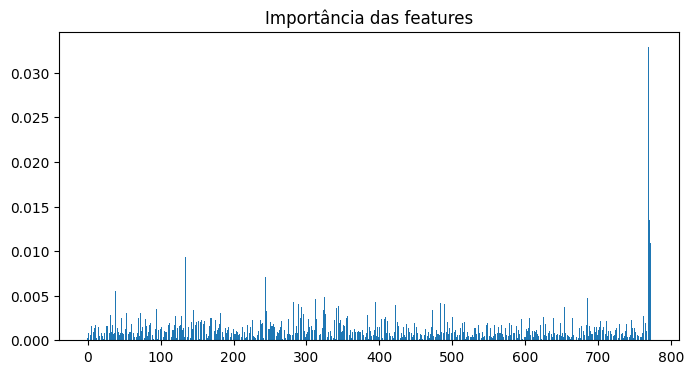

In [ ]:
importances = pipeline.named_steps['classifier'].feature_importances_

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(range(len(importances)), importances)
plt.title("Importância das features")
plt.show()


### Análise da Matriz de Confusão

Nesta etapa, visualizamos a Matriz de Confusão para entender o desempenho do modelo em prever corretamente as classes "Match" e "Não Match". A matriz nos ajuda a identificar a quantidade de Verdadeiros Positivos, Verdadeiros Negativos, Falsos Positivos e Falsos Negativos, fornecendo uma visão detalhada dos tipos de erros que o modelo está cometendo.

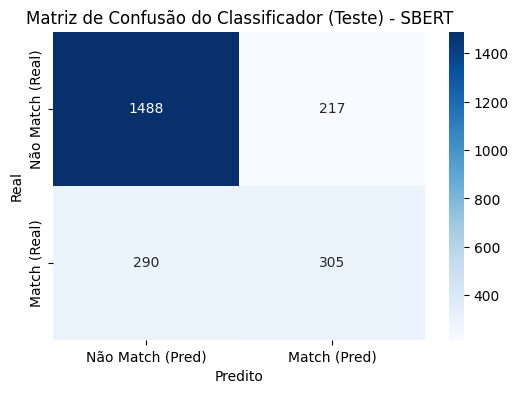

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Match (Pred)', 'Match (Pred)'],
            yticklabels=['Não Match (Real)', 'Match (Real)'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão do Classificador (Teste) - SBERT')
plt.show()

### Experimentação de Limiares de Probabilidade

Experimentamos diferentes limiares de probabilidade para a classificação. O objetivo é encontrar um ponto de corte que otimize o desempenho do modelo, buscando um melhor equilíbrio entre métricas como Precision e Recall, considerando as necessidades do problema (por exemplo, minimizar falsos negativos).

In [ ]:
y_proba = pipeline.predict_proba(X_test)[:, 1]

limiar_novo = 0.3
y_pred_ajustado = (y_proba > limiar_novo).astype(int)

print(f"\n--- Avaliação com Limiar Ajustado ({limiar_novo}) ---")
print(classification_report(y_test, y_pred_ajustado))


--- Avaliação com Limiar Ajustado (0.3) ---
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1705
           1       0.51      0.63      0.56       595

    accuracy                           0.75      2300
   macro avg       0.68      0.71      0.69      2300
weighted avg       0.77      0.75      0.76      2300



### Experimentação com XGBoostClassifier

Por fim, realizamos a modelagem utilizando o XGBoostClassifier, um modelo reconhecido por sua eficácia e capacidade de lidar bem com bases de dados desbalanceadas.

In [ ]:
from xgboost import XGBClassifier

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb_model)
])

pipeline.fit(X_train_res, y_train_res)

# Avaliação
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


c:\Users\Leonardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:14:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1705
           1       0.58      0.51      0.55       595

    accuracy                           0.78      2300
   macro avg       0.71      0.69      0.70      2300
weighted avg       0.77      0.78      0.77      2300



In [ ]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba >= 0.3).astype(int)  # Ou 0.25, 0.35

print(classification_report(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1705
           1       0.51      0.63      0.56       595

    accuracy                           0.75      2300
   macro avg       0.68      0.71      0.69      2300
weighted avg       0.77      0.75      0.76      2300



Continuando a experimentação de limiares, analisamos o impacto de diferentes pontos de corte nas métricas de avaliação (Precision, Recall e F1-score) para entender o trade-off e selecionar o limiar mais adequado para o objetivo do projeto.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

for thresh in [0.2, 0.25, 0.3, 0.35, 0.4]:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred_thresh, average='binary')
    print(f"Threshold: {thresh:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {f:.2f}")


Threshold: 0.20 | Precision: 0.47 | Recall: 0.71 | F1: 0.57
Threshold: 0.25 | Precision: 0.49 | Recall: 0.66 | F1: 0.56
Threshold: 0.30 | Precision: 0.51 | Recall: 0.63 | F1: 0.56
Threshold: 0.35 | Precision: 0.53 | Recall: 0.59 | F1: 0.56
Threshold: 0.40 | Precision: 0.55 | Recall: 0.56 | F1: 0.55


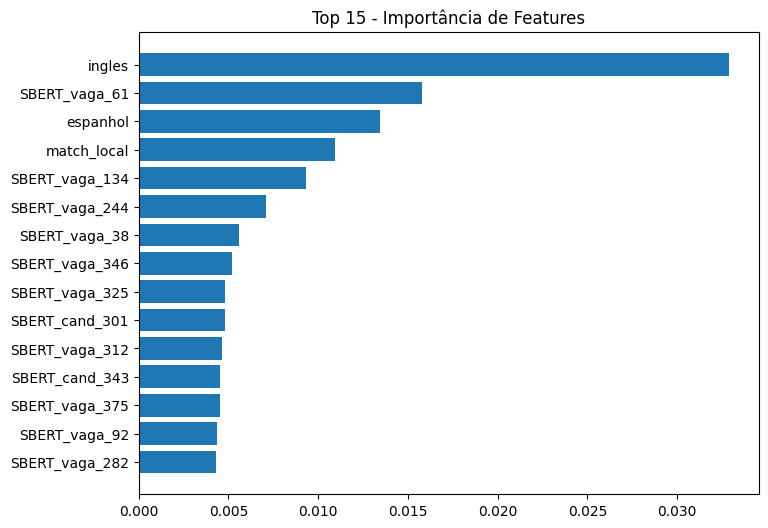

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

feat_names = (
    ['SBERT_vaga_'+str(i) for i in range(X_vaga.shape[1])] +
    ['SBERT_cand_'+str(i) for i in range(X_candidato.shape[1])] +
    ['match_bin', 'ingles', 'espanhol', 'diff_senioridade', 'match_local']
)

importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[-15:]  # top 15
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.title("Top 15 - Importância de Features")
plt.show()


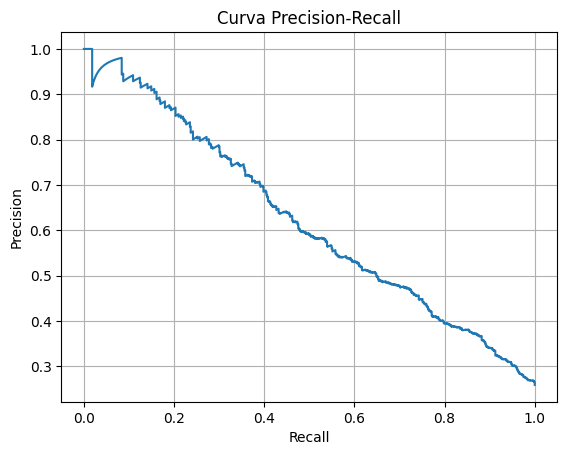

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thresh = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid()
plt.show()


In [ ]:
import joblib
import os

if not os.path.exists('modelos_salvos'):
    os.makedirs('modelos_salvos')

# Salve o pipeline treinado
joblib.dump(pipeline, 'modelos_salvos/xgb_pipeline_treinado.pkl')

print("Pipeline do XGBoost salvo em 'modelos_salvos/xgb_pipeline_treinado.pkl'")

Pipeline do XGBoost salvo em 'modelos_salvos/xgb_pipeline_treinado.pkl'


In [ ]:
limiar_ideal_xgb = 0.20
with open('modelos_salvos/limiar_xgb.txt', 'w') as f:
    f.write(str(limiar_ideal_xgb))

print(f"Limiar ideal ({limiar_ideal_xgb}) salvo em 'modelos_salvos/limiar_xgb.txt'")

Limiar ideal (0.2) salvo em 'modelos_salvos/limiar_xgb.txt'
